In [1]:
import sys, os, glob
sys.path.append('/home/gddaslab/mxp140/tcr_project_ultimate')
from constants import patient_names, max_kr_panpep, max_kr_vdjdb, max_kr_mcpas

In [2]:
import tqdm
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from pdf import ci_pdf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import linregress, ttest_ind
from concurrent.futures import ProcessPoolExecutor

In [3]:
asterisk = '\u2217'
p_value_stars = {0.001: f'{asterisk}{asterisk}{asterisk}', 0.01: f'{asterisk}{asterisk}', 0.05: f'{asterisk}'}
def get_asterisks(p_value):
    for threshold in sorted(p_value_stars.keys()):
        if p_value < threshold:
            return p_value_stars[threshold]
    return 'ns'

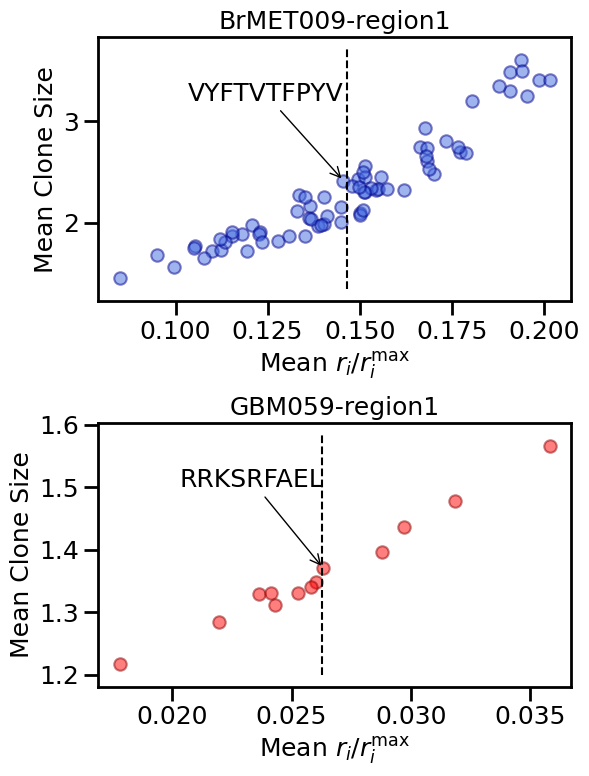

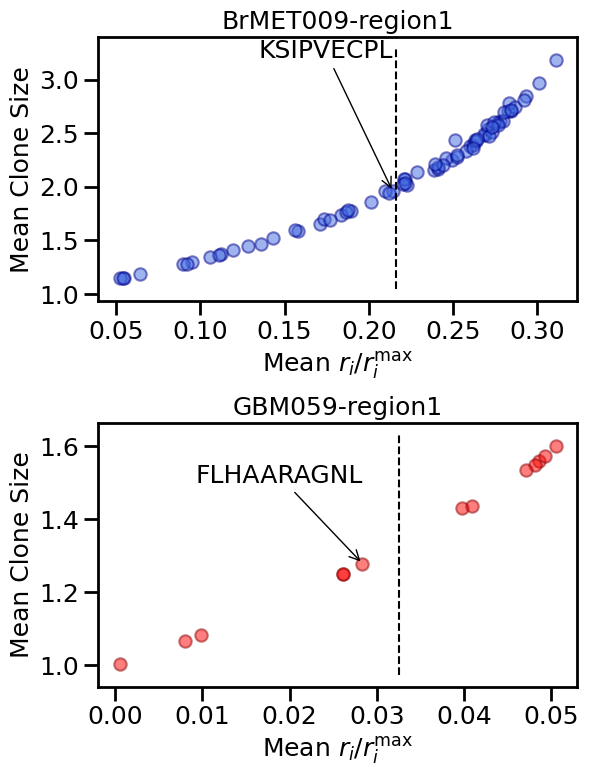

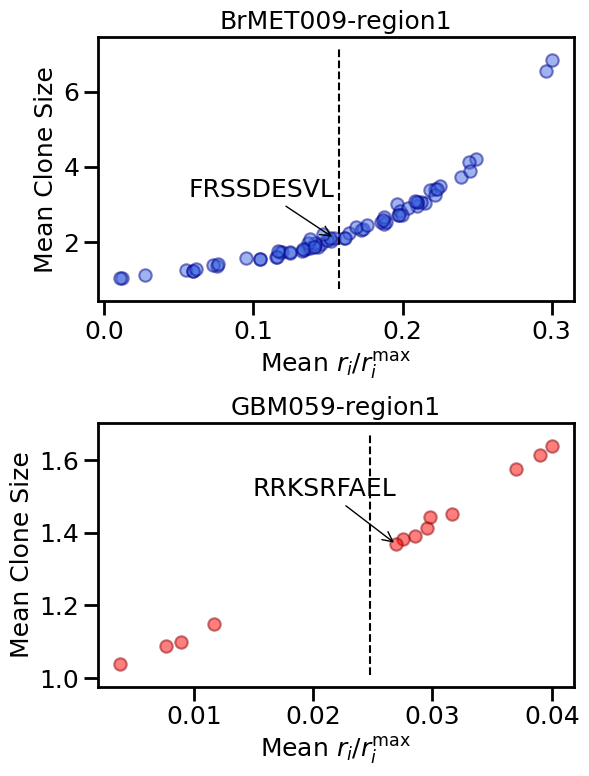

In [14]:
def fig4b_left():
    for data_type in ['panpep', 'vdjdb', 'mcpas']:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3*2, 3.93*2))
        for i, patient_id in enumerate(['BrMET009', 'GBM059']):
            region_number = 1
            mean_kr_and_clone_size_filename = f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_region{region_number}_neoantigen_specific_mean_kr_and_clone_size_from_{data_type.upper()}.csv'
            df = pd.read_csv(mean_kr_and_clone_size_filename, sep=',')

            if data_type == 'panpep':
                mean_kr_from_all_peptides = np.mean(pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}/{patient_id}_region{region_number}.csv', sep=',')['kr'].values/max_kr_panpep)
            if data_type == 'vdjdb':
                mean_kr_from_all_peptides = np.mean(pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/{patient_id}_region{region_number}.csv', sep=',')['kr_vdjdb'].values/max_kr_vdjdb)
            if data_type == 'mcpas':
                mean_kr_from_all_peptides = np.mean(pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/{patient_id}_region{region_number}.csv', sep=',')['kr_mcpas'].values/max_kr_mcpas)
            
            # Find the index of the closest value
            index_closest_to_mean = (np.abs(df['mean_kr'] - mean_kr_from_all_peptides)).idxmin()
            closest_peptide = df.loc[index_closest_to_mean]['peptide']
        
            ax = axes[i]
            sns.scatterplot(data=df, x='mean_kr', y='mean_clone_size', s=80, ax=ax, facecolors='royalblue' if 'BrMET' in patient_id else 'red', alpha=0.5, edgecolors='darkblue' if 'BrMET' in patient_id else 'darkred', linewidth=1.5)
            ax.vlines(x=mean_kr_from_all_peptides, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', color='black', label='Mean kr when\nmixture of all of the peptides  is used')
            
            ax.set_xlabel(r"Mean $r_i$/$r^{\text{max}}_i$", fontsize=18)
            ax.set_ylabel('Mean Clone Size', fontsize=18)
            
            # ax.xaxis.set_major_locator(ticker.MultipleLocator(0.04 if i==0 else 0.005))
            # ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02 if i==0 else 0.0025))
            # ax.yaxis.set_major_locator(ticker.MultipleLocator(1 if i==0 else 0.1))
            # ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5 if i==0 else 0.05))
            
            for label in ax.get_xticklabels():
                label.set_fontsize(18)
            for label in ax.get_yticklabels():
                label.set_fontsize(18)
            
            ax.tick_params(
                axis="x", which="major", direction="out", length=10, width=2, labelsize=18
            )
            ax.tick_params(
                axis="x", which="minor", direction="out", length=5, width=2, labelsize=18
            )
            ax.tick_params(
                axis="y", which="major", direction="out", length=10, width=2, labelsize=18
            )
            ax.tick_params(
                axis="y", which="minor", direction="out", length=5, width=2, labelsize=18
            )
            
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            
            # ax.legend(loc='upper left', fontsize=12, frameon=False)
            ax.set_title(f'{patient_id}-region{region_number}', fontsize=18)
            
            ax.annotate(closest_peptide, 
                    xy=(df.loc[index_closest_to_mean]['mean_kr'], df.loc[index_closest_to_mean]['mean_clone_size']),
                    xytext=(df.loc[index_closest_to_mean]['mean_kr'], 3.2 if i==0 else 1.5),
                    arrowprops=dict(arrowstyle='->', color='black'),
                    ha='right',
                    fontsize=18)
        
        plt.tight_layout()
        plt.savefig(f'fig4b_left-{data_type}.png', format='png', bbox_inches='tight', dpi=320)
        plt.show()
fig4b_left()

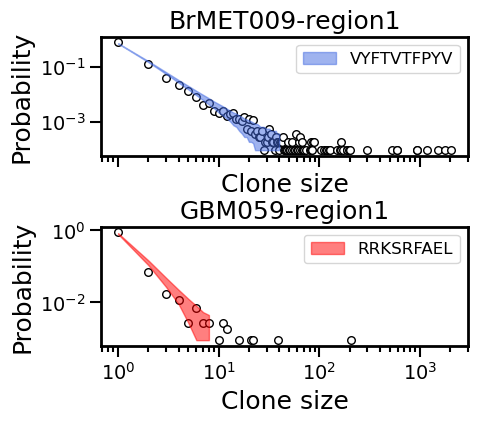

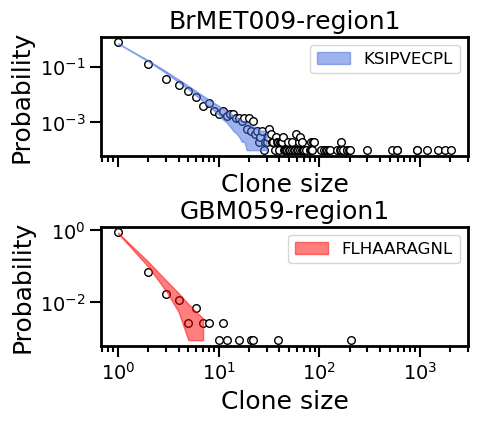

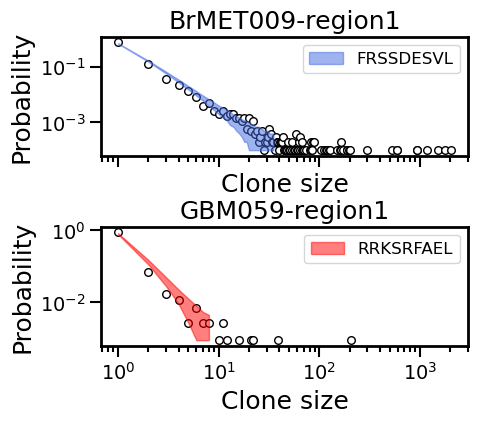

In [29]:
def fig4b_right():
    for data_type in ['panpep', 'vdjdb', 'mcpas']:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.73, 4.01), sharex=True, gridspec_kw={'wspace':1.5, 'hspace':0.6}) 
        for i, patient_id in enumerate(['BrMET009', 'GBM059']):
            region_number = 1
            mean_kr_and_clone_size_filename = f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_region{region_number}_neoantigen_specific_mean_kr_and_clone_size_from_{data_type.upper()}.csv'
            df = pd.read_csv(mean_kr_and_clone_size_filename, sep=',')
        
            with h5py.File(f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_region{region_number}_model_results_from_{data_type}.h5', 'r') as f:
                data_config = f['data_config'][:]
                data_config = np.unique(data_config, return_counts=True)
                x_data, y_data = data_config[0], data_config[1] / np.sum(data_config[1])
                # print(patient_id, region_number, np.max(x_data))
            
            if data_type == 'panpep':
                mean_kr_from_all_peptides = np.mean(pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}/{patient_id}_region{region_number}.csv', sep=',')['kr'].values/max_kr_panpep)
            if data_type == 'vdjdb':
                mean_kr_from_all_peptides = np.mean(pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/{patient_id}_region{region_number}.csv', sep=',')['kr_vdjdb'].values/max_kr_vdjdb)
            if data_type == 'mcpas':
                mean_kr_from_all_peptides = np.mean(pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/{patient_id}_region{region_number}.csv', sep=',')['kr_mcpas'].values/max_kr_mcpas)
            # Find the index of the closest value
            index_closest_to_mean = (np.abs(df['mean_kr'] - mean_kr_from_all_peptides)).idxmin()
            closest_peptide = df.loc[index_closest_to_mean]['peptide']
        
            config_by_closest_peptide = np.load(f'/home/gddaslab/mxp140/tcr_project_ultimate/results/config_{patient_id}_region{region_number}_from_{closest_peptide}_from_{data_type.upper()}.npz')['array_2d']
            least_number_of_observations = 10
            ci_df = ci_pdf(config_by_closest_peptide, least_number_of_observations=least_number_of_observations)
            ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]

            ax = axes[i]
            ax.scatter(x_data, y_data, s=30, facecolors='white', alpha=1.0, edgecolors='black', zorder=1)
            ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='royalblue' if 'BrMET' in patient_id else 'red', zorder=2, alpha=0.5, label=f'{closest_peptide}')
            
            ax.set_xscale('log')
            ax.set_yscale('log')
            # offset_x = 0.30
            # ax.set_xlim(min(x_data) - offset_x * min(x_data), 3*1e3 + offset_x * 3*1e3)
            
            ax.set_xlabel(r"Clone size", fontsize=18)
            ax.set_ylabel('Probability', fontsize=18)
            for label in ax.get_xticklabels():
                label.set_fontsize(18)
            for label in ax.get_yticklabels():
                label.set_fontsize(18)
            ax.tick_params(
                axis="x", which="major", direction="out", length=8, width=1.5, labelsize=14
            )
            ax.tick_params(
                axis="x", which="minor", direction="out", length=4, width=1.5, labelsize=14
            )
            ax.tick_params(
                axis="y", which="major", direction="out", length=8, width=1.5, labelsize=14
            )
            ax.tick_params(
                axis="y", which="minor", direction="out", length=4, width=1.5, labelsize=14
            )
            
            for spine in ax.spines.values():
                spine.set_linewidth(2)
            
            ax.legend(loc='upper right', fontsize=12)
            ax.set_title(f'{patient_id}-region{region_number}', fontsize=18)
        
        # plt.tight_layout()
        plt.savefig(f'fig4b_right-{data_type}.png', format='png', bbox_inches='tight', dpi=320)
        plt.show()
fig4b_right()

Processing GBM032: 100%|██████████| 23/23 [00:00<00:00, 23.24it/s]
/tmp/ipykernel_203381/395496445.py:14: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  region_level_data = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/ergo2_output_with_regions.csv',
Processing GBM079: 100%|██████████| 84/84 [00:01<00:00, 83.87it/s] 


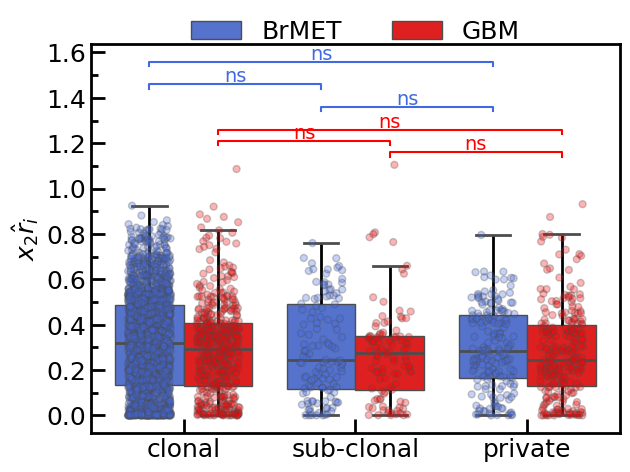

Processing GBM032: 100%|██████████| 23/23 [00:00<00:00, 23.30it/s]
/tmp/ipykernel_203381/395496445.py:14: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  region_level_data = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/ergo2_output_with_regions.csv',
Processing GBM079: 100%|██████████| 84/84 [00:00<00:00, 125.18it/s]


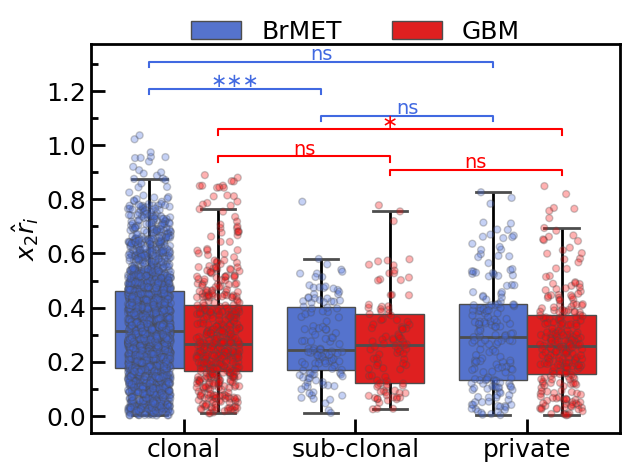

In [30]:
def fig4c():
    max_kr_dict = {'panpep':max_kr_panpep, 'vdjdb':max_kr_vdjdb, 'mcpas':max_kr_mcpas}
    for data_type in ['panpep', 'vdjdb', 'mcpas'][1:]:
        params_df = pd.read_excel("/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx",
                                engine='openpyxl', sheet_name='parameters')
        max_kr = max_kr_dict.get(data_type)
        results = []

        for patient_id in patient_names:
            if data_type == 'panpep':
                region_level_data = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv', 
                                            sep=',', comment='#')
            else:
                region_level_data = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/ERGOII/{patient_id}/ergo2_output_with_regions.csv', 
                                            sep=',', comment='#')
            regions = [col for col in region_level_data.columns if 'region' in col]

            # Create a mapping of peptides to regions
            neoantigens = {region: set(region_level_data[region_level_data[region] == 'Yes']['Peptide']) for region in regions}
            all_peptides = set.union(*neoantigens.values())

            # Pre-filter patient-specific parameters for faster lookup
            patient_params = params_df[params_df["Patient"] == patient_id].set_index("Region")

            for peptide in tqdm.tqdm(all_peptides, total=len(all_peptides), desc=f'Processing {patient_id}: '):
                # Determine clonality
                peptide_count = sum(peptide in neo for neo in neoantigens.values())
                is_clonal = peptide_count == len(regions)
                is_subclonal = 1 < peptide_count < len(regions)
                is_private = peptide_count == 1

                # Compute mean_kr_times_x2_panpep efficiently
                mean_kr_times_x2 = []
                for i, region in enumerate(regions):
                    if peptide in neoantigens[region]:
                        data = region_level_data[(region_level_data[region] == 'Yes') & (region_level_data['Peptide'] == peptide)]
                        if not data.empty:
                            x2_value = patient_params.loc[region, f'x2_{data_type}'] if region in patient_params.index else np.nan
                            mean_kr = data['Score' if data_type == 'panpep' else ('Score_vdjdb' if data_type == 'vdjdb' else 'Score_mcpas')].mean() * len(neoantigens[region]) / max_kr
                            mean_kr_times_x2.append(mean_kr * x2_value)

                results.append([patient_id, peptide, is_clonal, is_subclonal, is_private, mean_kr_times_x2])
            

        # Convert results to DataFrame
        resulting_df = pd.DataFrame(results, columns=['patient', 'peptide', 'clonal', 'sub-clonal', 'private', 'mean_kr'])
        
        # Add patient type
        resulting_df['patient_type'] = resulting_df['patient'].apply(lambda x: 'BrMET' if 'BrMET' in x else 'GBM')

        # Explode and reshape data
        df_exploded = resulting_df.explode('mean_kr')
        df_melted = df_exploded.melt(id_vars=['patient', 'peptide', 'patient_type', 'mean_kr'], 
                                    value_vars=['clonal', 'sub-clonal', 'private'], 
                                    var_name='category', value_name='value')
        df_filtered = df_melted[df_melted['value']]

        ax = sns.boxplot(x="category", y="mean_kr", hue="patient_type", palette={'BrMET': 'royalblue', 'GBM': 'red'}, data=df_filtered, showfliers=False, whiskerprops={"color": "black", "linewidth": 2}, medianprops={"linewidth":2}, capprops={"linewidth":2})

        # add stripplot with dodge=True
        sns.stripplot(x="category", y="mean_kr", hue="patient_type", palette={'BrMET': 'royalblue', 'GBM': 'red'}, data=df_filtered, dodge=True, jitter=0.25, ax=ax, linewidth=1, alpha=0.3)

        # Create arrays for each category
        clonal_brmet = df_filtered[(df_filtered['category'] == 'clonal') & (df_filtered['patient_type'] == 'BrMET')]['mean_kr'].values.astype(float)
        clonal_gbm = df_filtered[(df_filtered['category'] == 'clonal') & (df_filtered['patient_type'] == 'GBM')]['mean_kr'].values.astype(float)
        subclonal_brmet = df_filtered[(df_filtered['category'] == 'sub-clonal') & (df_filtered['patient_type'] == 'BrMET')]['mean_kr'].values.astype(float)
        subclonal_gbm = df_filtered[(df_filtered['category'] == 'sub-clonal') & (df_filtered['patient_type'] == 'GBM')]['mean_kr'].values.astype(float)
        private_brmet = df_filtered[(df_filtered['category'] == 'private') & (df_filtered['patient_type'] == 'BrMET')]['mean_kr'].values.astype(float)
        private_gbm = df_filtered[(df_filtered['category'] == 'private') & (df_filtered['patient_type'] == 'GBM')]['mean_kr'].values.astype(float)

        p_value_clonal_vs_subclonal_brmet = ttest_ind(clonal_brmet, subclonal_brmet, equal_var=False).pvalue
        p_value_clonal_vs_private_brmet = ttest_ind(clonal_brmet, private_brmet, equal_var=False).pvalue
        p_value_subclonal_vs_private_brmet = ttest_ind(subclonal_brmet, private_brmet, equal_var=False).pvalue
        p_value_clonal_vs_subclonal_gbm = ttest_ind(clonal_gbm, subclonal_gbm, equal_var=False).pvalue
        p_value_clonal_vs_private_gbm = ttest_ind(clonal_gbm, private_gbm, equal_var=False).pvalue
        p_value_subclonal_vs_private_gbm = ttest_ind(subclonal_gbm, private_gbm, equal_var=False).pvalue
        p_values = [p_value_clonal_vs_private_brmet, 
                    p_value_clonal_vs_subclonal_brmet, 
                    p_value_subclonal_vs_private_brmet, 
                    p_value_clonal_vs_private_gbm, 
                    p_value_clonal_vs_subclonal_gbm, 
                    p_value_subclonal_vs_private_gbm]

        x1s = [-0.2, -0.2, 0.8, 0.2, 0.2, 1.2]
        x2s = [1.8, 0.8, 1.8, 2.2, 1.2, 2.2]
        ys_dict= {'panpep': [1.1, 1.0, 0.95, 0.85, 0.8, 0.75], 'vdjdb': [1.55, 1.45, 1.35, 1.25, 1.2, 1.15], 'mcpas': [1.30, 1.2, 1.1, 1.05, 0.95, 0.90]}
        hs = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
        colors = ['royalblue', 'royalblue', 'royalblue', 'red', 'red', 'red']
        for x1, x2, y, h, color, p_value in zip(x1s, x2s, ys_dict.get(data_type), hs, colors, p_values):
            # print(f'{get_asterisks(p_value)}')
            ax.plot([x1, x1, x2, x2], [y - h / 2, y + h / 2, y + h / 2, y - h / 2], lw=1.5, color=color)
            ax.text((x1 + x2) * .5, y + h * 0.1, f'{get_asterisks(p_value)}', ha='center', va='bottom', color=color, fontsize=14)
            
        # Increase font size for tick labels
        xtick_labels, ytick_labels = ax.get_xticklabels(), ax.get_yticklabels()
        for label in xtick_labels + ytick_labels:
            label.set_fontsize(24)

        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

        ax.tick_params(
            axis="x", which="major", direction="in", length=10, width=2, labelsize=18
        )
        ax.tick_params(
            axis="x", which="minor", direction="in", length=5, width=2, labelsize=18
        )
        ax.tick_params(
            axis="y", which="major", direction="in", length=10, width=2, labelsize=18
        )
        ax.tick_params(
            axis="y", which="minor", direction="in", length=5, width=2, labelsize=18
        )

        for spine in ax.spines.values():
            spine.set_linewidth(2)

        # ax.set_ylim(top=1.3)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(0.5, 1.12), fontsize=18, loc='upper center', ncols=2, frameon=False)
        ax.set_xlabel('', fontsize=18)
        ax.set_ylabel(r'$x_2 \hat{r}_i$', fontsize=18)
        
        plt.tight_layout()
        plt.savefig(f'fig4c-{data_type}.png', format='png', dpi=320)
        plt.show()
    return df_filtered
a = fig4c()
